In [42]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras import backend as K
import albumentations as A
from functools import partial
from tqdm import tqdm

In [43]:
from tensorflow.keras.callbacks import Callback


In [44]:
seed = 42
np.random.seed(seed)

In [45]:
tf.config.list_physical_devices('GPU')

[]

In [46]:
os.listdir('/kaggle/input/isic2018-challenge-task1-data-segmentation')

['ISIC2018_Task1-2_Training_Input',
 'ISIC2018_Task1_Training_GroundTruth',
 'ISIC2018_Task1-2_Test_Input',
 'ISIC2018_Task1-2_Validation_Input']

In [47]:
train_img_folder_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input"
train_label_folder_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth"
val_folder_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Validation_Input"
test_folder_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Test_Input"

In [48]:
# Checking if paths are correct
exist_condition = os.path.exists(train_img_folder_path) and os.path.exists(train_label_folder_path) and os.path.exists(val_folder_path) and os.path.exists(test_folder_path)
print("Files not found") if exist_condition == False else None

In [49]:
# This array contains paths for the images. Folder contains a text file, we only want images I used endswith function to get jpg files
train_images_path = np.sort([os.path.join(train_img_folder_path, i) for i in os.listdir(train_img_folder_path) if i.endswith('.jpg')])
train_labels_path = np.sort([os.path.join(train_label_folder_path, i) for i in os.listdir(train_label_folder_path) if i.endswith('.png')])
test_images_path = np.sort([os.path.join(test_folder_path, i) for i in os.listdir(test_folder_path) if i.endswith('.jpg')])

In [50]:
train_split = 0.8
val_images_path = train_images_path[int(train_split*len(train_images_path)):]
val_labels_path = train_labels_path[int(train_split*len(train_labels_path)):]
train_images_path = train_images_path[:int(train_split*len(train_images_path))]
train_labels_path = train_labels_path[:int(train_split*len(train_labels_path))]

In [51]:
len(train_images_path) + len(val_images_path)

2594

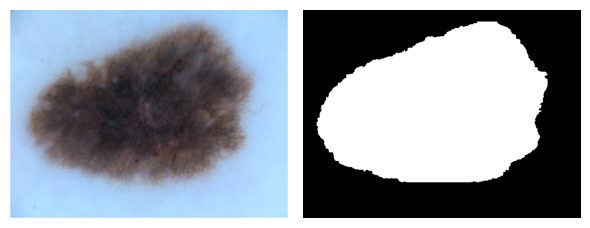

In [52]:
img1 = Image.open(train_images_path[0])
img1_label = Image.open(train_labels_path[0])

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img1_label, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show();

# Load the Data

In [53]:
IMG_SIZE = 256
IMG_CHANNELS = 3
batch_size = 8
buffer_size = 1000
steps_per_epoch = len(train_images_path) // batch_size
AUTOTUNE = tf.data.AUTOTUNE

In [54]:
x_train_ds = tf.data.Dataset.list_files(train_images_path, seed=seed)
y_train_ds = tf.data.Dataset.list_files(train_labels_path, seed=seed)
x_val_ds = tf.data.Dataset.list_files(val_images_path, seed=seed)
y_val_ds = tf.data.Dataset.list_files(val_labels_path, seed=seed)

In [55]:
def parse_image(img_path, size=(256,256)):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size)
    return image

def parse_gt(gt_path, size=(256,256)):
    gt = tf.io.read_file(gt_path)
    gt = tf.image.decode_png(gt, channels=1)
    gt = tf.image.resize(gt, size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    gt = tf.where(gt == 0, 0, 1)
    gt = tf.image.convert_image_dtype(gt, tf.int32)
    return gt

In [56]:
x_train_ds = x_train_ds.map(parse_image)
y_train_ds = y_train_ds.map(parse_gt)
x_val_ds = x_val_ds.map(parse_image)
y_val_ds = y_val_ds.map(parse_gt)

In [57]:
print(f'Train x size: {len(x_train_ds)}')
print(f'Validation x size: {len(x_val_ds)}')
print(f'Train y size: {len(y_train_ds)}')
print(f'Validation y size: {len(y_val_ds)}')

Train x size: 2075
Validation x size: 519
Train y size: 2075
Validation y size: 519


In [58]:
train_ds = tf.data.Dataset.zip((x_train_ds, y_train_ds))
val_ds = tf.data.Dataset.zip((x_val_ds, y_val_ds))

In [59]:
def augment(image, mask, size=(256, 256)):
  transforms = A.Compose([
      A.OneOf([
          A.Transpose(),
          A.VerticalFlip(),
          A.HorizontalFlip(),
          A.RandomRotate90(),
          A.NoOp()], p=0.75),

      A.ShiftScaleRotate(p=0.1),
      A.GridDistortion(p=0.1),
      A.ElasticTransform(p=0.1),

      A.OneOf([
          A.RandomBrightnessContrast(),    
          A.RandomGamma()], p=0.2)
      
    ], additional_targets={'mask': 'mask'})

  data = {"image":image, "mask":mask}
  aug_data = transforms(**data)

  aug_img = aug_data["image"]
  aug_img = tf.cast(aug_img, tf.float32)

  aug_mask = aug_data["mask"]
  # Making sure labels are binary (background or label)
  aug_mask = np.where(aug_mask == 0, 0, 1)
  aug_mask = tf.cast(aug_mask, tf.int32)
  return aug_img, aug_mask

# I got "Tensor has no attribute .numpy() method" error. To fix this I used tf.numpy_function()
def process_data(image, mask, h=256, w=256):
  image, mask = tf.numpy_function(func=augment, inp=[image, mask], Tout=(tf.float32, tf.int32))
  # The datasets loses its shape after applying a tf.numpy_function, so this is 
  # necessary for the sequential model and when inheriting from the model class.
  image.set_shape((h, w, 3))
  mask.set_shape((h, w, 1))
  return image, mask

In [60]:
train_ds = (
    train_ds
    .cache()
    .map(partial(process_data))
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=AUTOTUNE)
)

# Not appliyingg augmentation on validation data.
val_ds = (
    val_ds
    .cache()
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=AUTOTUNE)
)

In [61]:
train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 1), dtype=tf.int32, name=None))

(8, 256, 256, 3)
(8, 256, 256, 1)


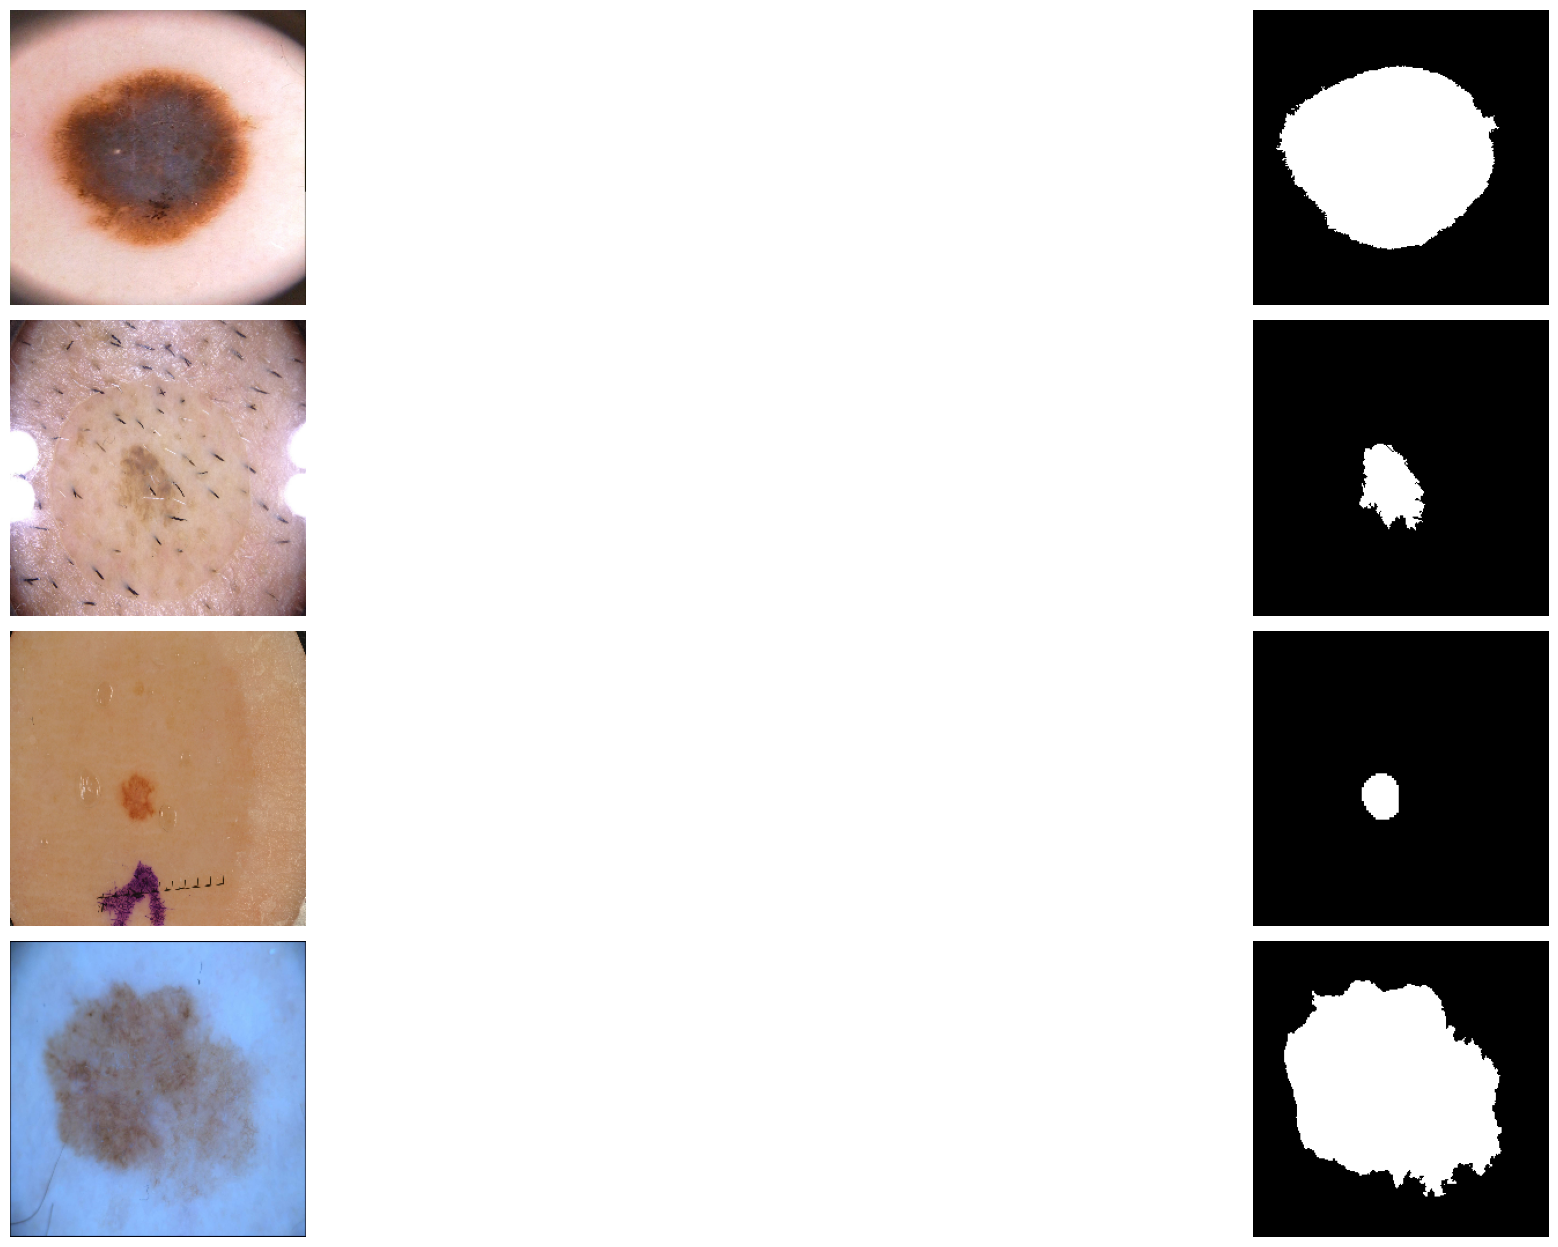

In [62]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.shape)
    plt.figure(figsize=(25, 25))
    for i in range(0, batch_size, 2):
        plt.subplot(batch_size, 2, i+1)
        plt.imshow(image[i])
        plt.axis('off')
        plt.subplot(batch_size, 2, i+2)
        plt.imshow(label[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

In [63]:
test_ds = (
    tf.data.Dataset.list_files(test_images_path)
    .map(parse_image)
    .batch(1))

In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, Input, concatenate, Multiply
from tensorflow.keras import Model

# Swin Transformer Block (For simplicity, using a custom block)
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, window_size, shift_size=0):
        super(SwinTransformerBlock, self).__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        # You can implement or import a pre-built Swin Transformer block here

    def build(self, input_shape):
        # Add layers such as multi-head self-attention, window partition, etc.
        pass
    
    def call(self, inputs):
        # Define forward pass logic using attention layers
        return inputs

# Attention Gate Layer for skip connections
def attention_gate(x, g, inter_channel=64):
    """
    Attention Gate mechanism to refine the skip connection.
    x: input feature map from encoder
    g: input feature map from decoder
    """
    # 1x1 convolution to reduce the number of channels
    psi = Conv2D(inter_channel, (1,1), activation='relu')(g)
    psi = Conv2D(1, (1,1), activation='sigmoid')(psi)
    return Multiply()([x, psi])

# Swin Transformer Encoder Block
def swin_encoder_block(inp, filters, padding='same', pool_stride=2, window_size=7, shift_size=0):
    # Use the Swin Transformer Block instead of Conv2D layers
    x = SwinTransformerBlock(filters, num_heads=4, window_size=window_size, shift_size=shift_size)(inp)
    p = MaxPooling2D(pool_size=(2, 2), strides=pool_stride)(x)
    return x, p

# Swin Transformer Decoder Block with Attention Gate
def swin_decoder_block(inp, filters, concat_layer, padding='same', window_size=7):
    # Upsample the feature maps
    x = Conv2DTranspose(filters, (2,2), strides=(2,2), padding=padding)(inp)
    # Apply Attention Gate to the skip connection
    x = attention_gate(x, concat_layer)  # Attention on the skip connection
    x = SwinTransformerBlock(filters, num_heads=4, window_size=window_size)(x)  # Swin Transformer Block
    return x

# Building the Model with Swin Transformer and Attention Gate
def build_model_with_swin(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    d1, p1 = swin_encoder_block(inputs, 64)
    d2, p2 = swin_encoder_block(p1, 128)
    d3, p3 = swin_encoder_block(p2, 256)
    d4, p4 = swin_encoder_block(p3, 512)
    
    # Midsection with a Swin Transformer block
    mid = SwinTransformerBlock(1024, num_heads=8, window_size=7)(p4) 
    
    e2 = swin_decoder_block(mid, 512, d4, window_size=7) 
    e3 = swin_decoder_block(e2, 256, d3, window_size=7)
    e4 = swin_decoder_block(e3, 128, d2, window_size=7) 
    e5 = swin_decoder_block(e4, 64, d1, window_size=7)
    
    # Final Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(e5)
    model = Model(inputs=[inputs], outputs=[outputs], name='SwinUnet')
    return model


In [65]:
#Evaluation Metrics
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    smooth = 1e-7  # Smooth to avoid division by zero
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def iou(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection / union
def precision(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    true_positive = K.sum(y_true_f * y_pred_f)
    false_positive = K.sum((1 - y_true_f) * y_pred_f)
    return true_positive / (true_positive + false_positive + K.epsilon())

def recall(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    true_positive = K.sum(y_true_f * y_pred_f)
    false_negative = K.sum(y_true_f * (1 - y_pred_f))
    return true_positive / (true_positive + false_negative + K.epsilon())
import time

def inference_time(model, data):
    start_time = time.time()
    model.predict(data)  # Make a prediction
    end_time = time.time()
    return end_time - start_time


In [66]:
#Loss
def bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, dtype=y_pred.dtype)
    bce = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
    dice = dice_coef(y_true, y_pred)
    return bce - K.log(dice)
def bce_dice_loss_log(y_true, y_pred):
    y_true = K.cast(y_true, dtype=y_pred.dtype)
    bce = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
    dice = dice_coef(y_true, y_pred)
    return bce + 1 - dice
def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)
def precision_recall_loss(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 1 - (2 * p * r) / (p + r + K.epsilon())  # This is the F1 score
def bce_precision_recall_loss(y_true, y_pred):
    bce = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1 = (2 * p * r) / (p + r + K.epsilon())
    return bce - f1


In [67]:
model = build_model_with_swin(IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=bce_dice_loss_log, 
              metrics=[dice_coef, iou, precision, recall, 'accuracy'])

In [68]:
model.summary()

Model: "SwinUnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swin_transformer_b… │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (SwinTransformerBl… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ swin_transformer… │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swin_transformer_b… │ (None, 128, 128,  │          0 │ max_pooling2d_4[… │
│ (SwinTransformerBl… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64, 3) │          0 │ swin_transformer… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swin_transformer_b… │ (None, 64, 64, 3) │          0 │ max_pooling2d_5[… │
│ (SwinTransformerBl… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32, 3) │          0 │ swin_transformer… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swin_transformer_b… │ (None, 32, 32, 3) │          0 │ max_pooling2d_6[… │
│ (SwinTransformerBl… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16, 3) │          0 │ swin_transformer… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swin_transformer_b… │ (None, 16, 16, 3) │          0 │ max_pooling2d_7[… │
│ (SwinTransformerBl… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │        256 │ swin_transformer… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │      6,656 │ swin_transformer… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32, 1) │         65 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Multiply)          │ 512)              │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swin_transformer_b… │ (None, 32, 32,    │          0 │ multiply_4[0][0]  │
│ (SwinTransformerBl… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │        256 │ swin_transformer… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 64, 64,    │    524,544 │ swin_transformer… │
│ (Conv2DTranspose)   │ 256)              │            │                 

 Total params: 696,581 (2.66 MB)

 Trainable params: 696,581 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
steps_per_epoch = int(len(train_images_path)*0.8 // batch_size)
val_steps = int(len(train_images_path)*0.2 // batch_size)

print(f"Batch Size: {batch_size}\nSteps_per_epoch: {steps_per_epoch}\nValidation_steps: {val_steps}")

Batch Size: 8
Steps_per_epoch: 207
Validation_steps: 51


In [70]:
callbacks = [
    EarlyStopping(monitor='val_dice_coef', patience=10, mode='max'),
    ModelCheckpoint(filepath='saved_model.keras', monitor='val_dice_coef', save_best_only=True),
    ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2, patience=5, verbose=1, min_lr=5e-7)
]

In [71]:
history = model.fit(train_ds, epochs=10, verbose=2,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=val_steps,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/10
207/207 - 562s - 3s/step - accuracy: 0.7991 - dice_coef: 0.2618 - iou: 0.1522 - loss: 1.2342 - precision: 0.2528 - recall: 0.3144 - val_accuracy: 0.7927 - val_dice_coef: 0.4135 - val_iou: 0.2628 - val_loss: 1.0513 - val_precision: 0.4917 - val_recall: 0.3694 - learning_rate: 0.0010
Epoch 2/10
207/207 - 411s - 2s/step - accuracy: 0.8111 - dice_coef: 0.3235 - iou: 0.1960 - loss: 1.1440 - precision: 0.3287 - recall: 0.3708 - val_accuracy: 0.7333 - val_dice_coef: 0.4198 - val_iou: 0.2690 - val_loss: 1.1023 - val_precision: 0.3649 - val_recall: 0.5224 - learning_rate: 0.0010
Epoch 3/10
207/207 - 359s - 2s/step - accuracy: 0.8185 - dice_coef: 0.3569 - iou: 0.2205 - loss: 1.0991 - precision: 0.3608 - recall: 0.4007 - val_accuracy: 0.7147 - val_dice_coef: 0.4626 - val_iou: 0.3052 - val_loss: 1.0738 - val_precision: 0.4186 - val_recall: 0.5434 - learning_rate: 0.0010
Epoch 4/10
207/207 - 356s - 2s/step - accuracy: 0.8120 - dice_coef: 0.3611 - iou: 0.2241 - loss: 1.1008 - precision: 0

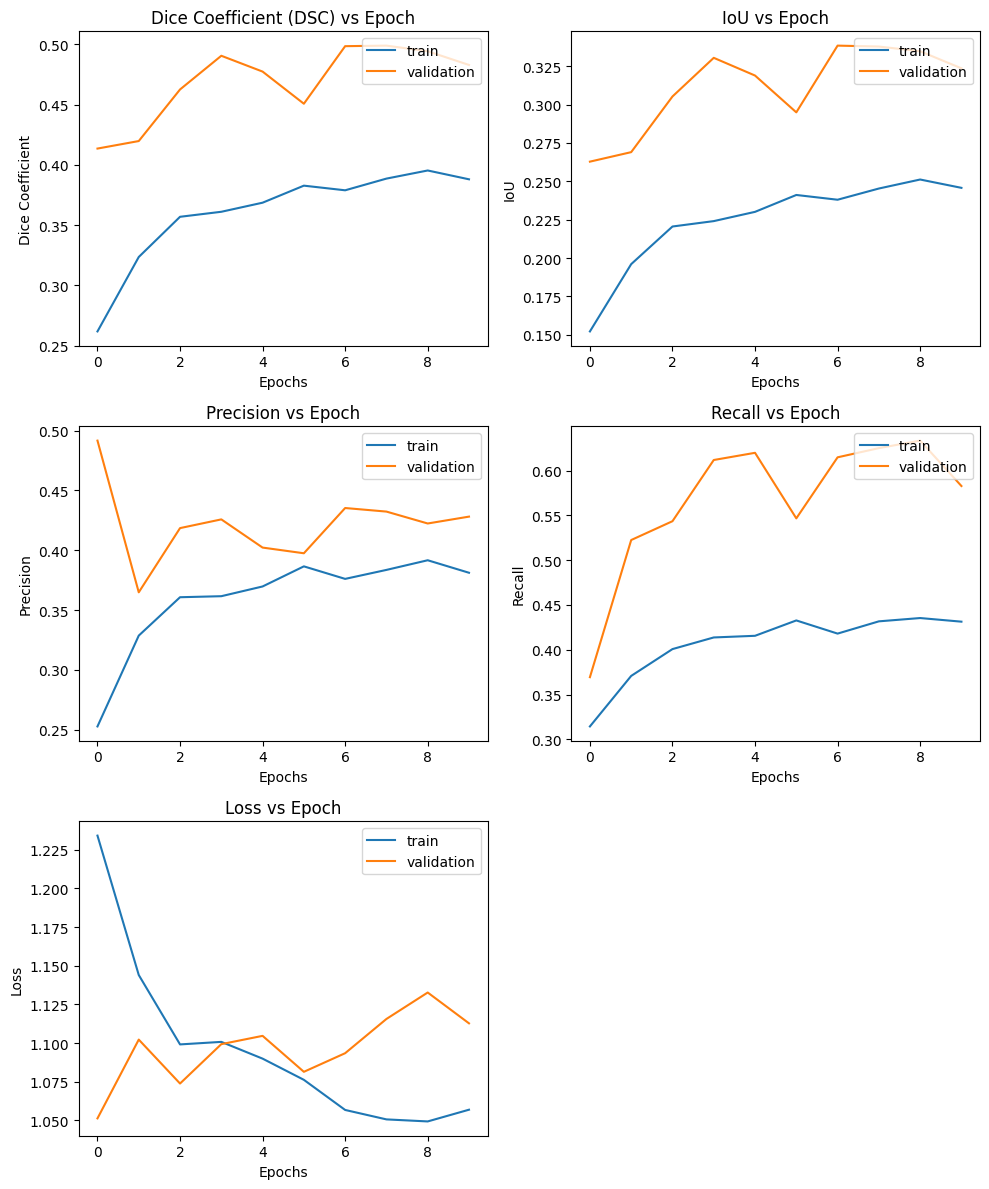

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))

# Dice coefficient plot
plt.subplot(3,2,1)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice Coefficient (DSC) vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

# IoU plot
plt.subplot(3,2,2)
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('IoU vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

# Precision plot
plt.subplot(3,2,3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Precision vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

# Recall plot
plt.subplot(3,2,4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

# Loss plot
plt.subplot(3,2,5)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

# Inference time plot (if you tracked this metric separately)
# For simplicity, assuming `inference_time` is in history.history
if 'inference_time' in history.history:
    plt.subplot(3,2,6)
    plt.plot(history.history['inference_time'])
    plt.title('Inference Time vs Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Inference Time (s)')
    plt.tight_layout()

plt.show()


In [73]:
raw_predictions = model.predict(test_ds)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 102s 101ms/step


In [74]:
predictions = np.where(raw_predictions < 0.5, 0, 1)

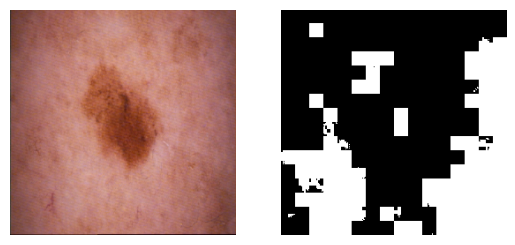

In [75]:
image = [images[0].numpy() for images in test_ds.take(1)]

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(image[0]) # Using index 0 because it is in shape of (1, 256, 256, 1)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(predictions[0], cmap='gray')
plt.show()